In [1]:
import sys
sys.path.append('/home/hashmi/ResearchBook/Tracking/Notebooks/Moore')
from central_import import *

figure_directory = '../../../Figures/FinalModel/'
os.makedirs(figure_directory,exist_ok=True)
set_plot_style()

In [2]:
#Calling the input file and shuffling the dataset
data = pd.read_parquet('../DataBuild/DownstreamTrackTrainingData.parquet').sample(frac=1,random_state=51)

In [3]:
x=data.drop(['isMatched'],axis=1)
y=data['isMatched']

columns=np.array(['P','Pt','Tx','Ty', 'X','Y','Eta','Phi','nUTHits','Chi2PerDoF'])
x.columns=columns

#Training Data
print(f"Dimension of the Data is : ",x.shape)
display(x.head())


Dimension of the Data is :  (2723937, 10)


,P,Pt,Tx,Ty,X,Y,Eta,Phi,nUTHits,Chi2PerDoF
433784,8189.772090,325.211148,-0.016746,-0.036040,-43.085033,-86.561920,3.918919,-2.005760,4,0.172747
1694589,8486.208200,878.609839,0.100799,-0.025982,246.978638,-62.572239,2.958313,-0.252271,4,0.543546
1437215,2809.355517,240.200632,0.032981,-0.079223,61.566750,-190.253845,3.150550,-1.176311,4,0.320558
177554,22305.965467,572.987270,-0.015344,0.020612,-39.130081,49.863842,4.354728,2.210740,4,0.211324
1407145,6983.081318,315.091139,0.032878,0.030971,87.272003,73.359505,3.791021,0.755543,4,0.423034


In [4]:
#Train-Test-Evaluation Split
x_train,x_temp,y_train,y_temp=train_test_split(x,y,stratify=y,random_state=35)
x_test,x_eval,y_test,y_eval=train_test_split(x_temp,y_temp,stratify=y_temp,random_state=35)

#Preprocessing of Train-Test Data
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x.columns)
x_eval=pd.DataFrame(scaler.transform(x_eval),columns=x.columns)
x_train,y_train=sampler.fit_resample(x_train,y_train)
# x_eval,y_eval=sampler.fit_resample(x_eval,y_eval)

#Catboost Pool Functionality
train_data=Pool(data=x_train,label=y_train)
test_data=Pool(data=x_test,label=y_test)
eval_data=Pool(data=x_eval,label=y_eval)

In [5]:
#Catboost Parameters for Training after Hyper-parameter Tuning.
catboost_params = {
    'eval_metric': 'AUC',
    'thread_count': 10,
    'learning_rate': 0.1,
    'iterations': 500,
    'depth': 6,
    'l2_leaf_reg': 3,
    'min_data_in_leaf': 10,
    'subsample': 0.8,
    'random_strength': 1,
    'border_count': 128,
    'early_stopping_rounds': 50
    }

#Model Training
model = CatBoostClassifier(**catboost_params)
model.fit(train_data,eval_set=test_data,verbose=100,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7742039	best: 0.7742039 (0)	total: 125ms	remaining: 1m 2s
100:	test: 0.8146762	best: 0.8146762 (100)	total: 9.74s	remaining: 38.5s
200:	test: 0.8343334	best: 0.8343334 (200)	total: 19.4s	remaining: 28.8s
300:	test: 0.8440991	best: 0.8440991 (300)	total: 28.7s	remaining: 19s
400:	test: 0.8504867	best: 0.8504867 (400)	total: 37.6s	remaining: 9.29s
499:	test: 0.8553100	best: 0.8553100 (499)	total: 46.3s	remaining: 0us

bestTest = 0.8553099646
bestIteration = 499



ROC-AUC Score :  77.55 %
F1 Score :  89.25 %


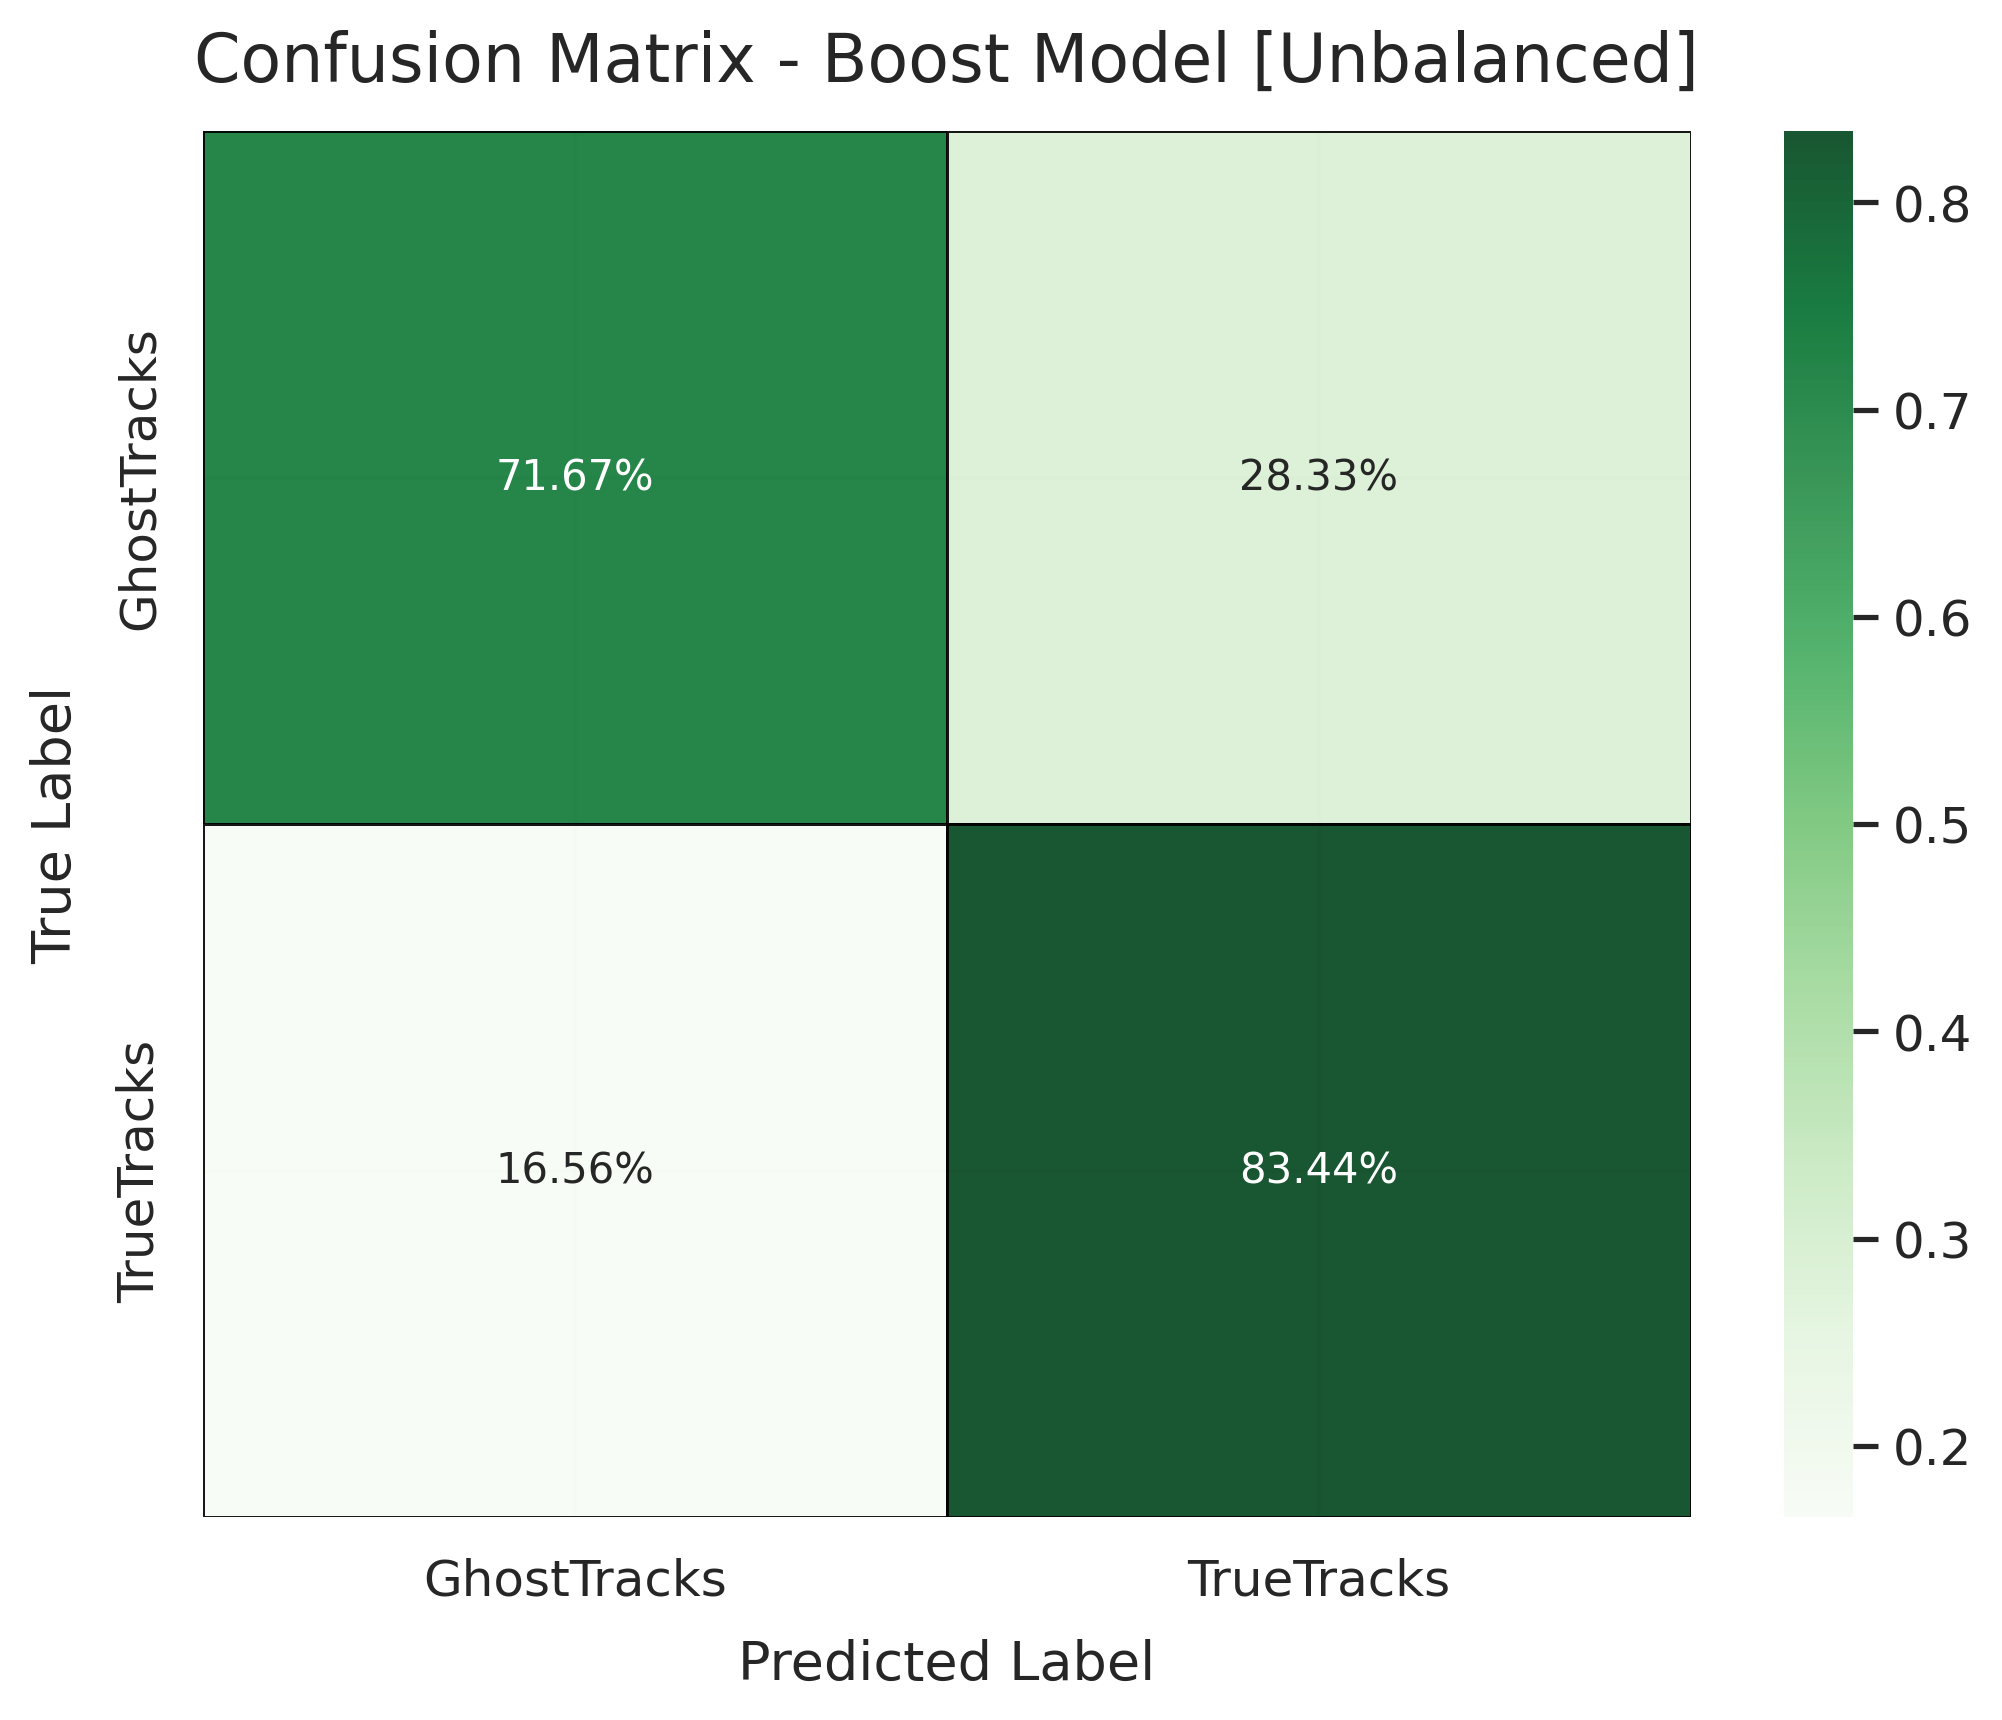

In [6]:
# Model Evaluation (UnBalanced Data)
y_predict=model.predict(x_test)
print(f'ROC-AUC Score : ',round(roc_auc_score(y_test,y_predict)*100,2),'%')
print(f'F1 Score : ',round(f1_score(y_test,y_predict)*100,2),'%')

# ConfusionMatrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_predict,normalize='true'), xticklabels=['GhostTracks', 'TrueTracks'],yticklabels=['GhostTracks', 'TrueTracks'], fmt='.2%',annot=True, annot_kws={'fontsize': 10}, 
            cmap='Greens',linewidths=0.7,linecolor='black',alpha=0.9)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Boost Model [Unbalanced]')
plt.savefig(f"{figure_directory}/Downstream_Catboost_CM_Unbalanced.png")
plt.show()

ROC-AUC Score :  77.45 %
F1 Score :  89.23 %


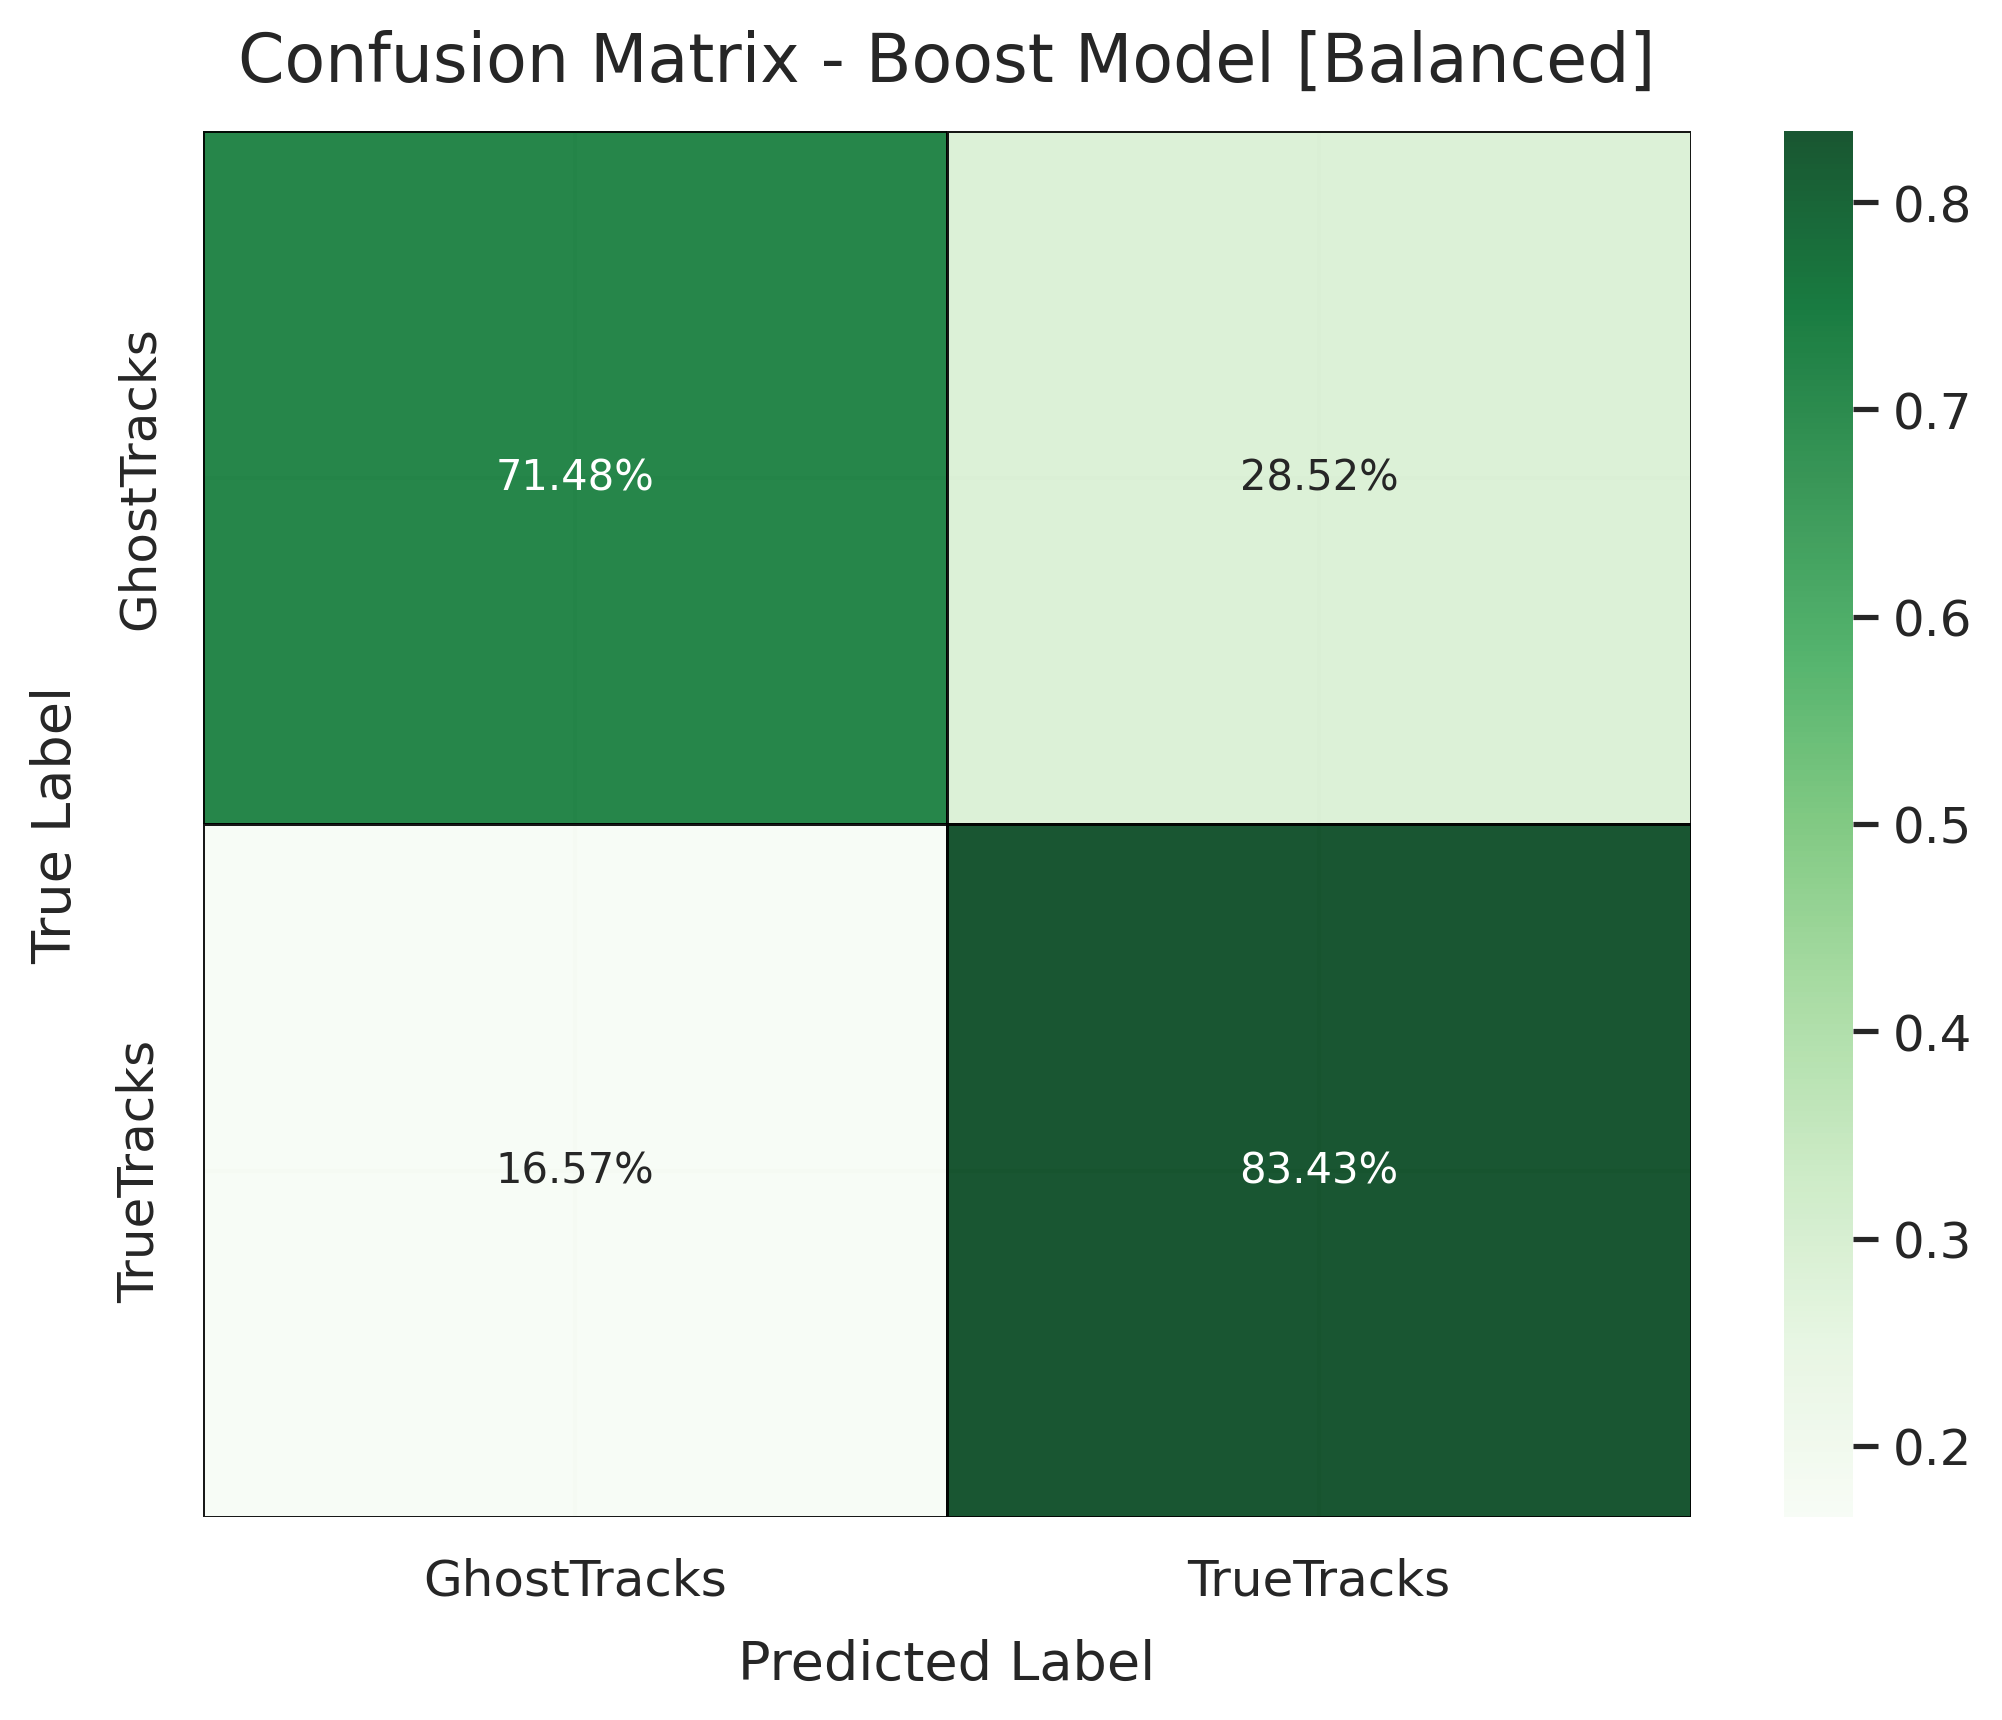

In [7]:
# Model Evaluation (Balanced Data)
y_predict=model.predict(x_eval)
print(f'ROC-AUC Score : ',round(roc_auc_score(y_eval,y_predict)*100,2),'%')
print(f'F1 Score : ',round(f1_score(y_eval,y_predict)*100,2),'%')

# ConfusionMatrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_eval, y_predict,normalize='true'), xticklabels=['GhostTracks', 'TrueTracks'],yticklabels=['GhostTracks', 'TrueTracks'], fmt='.2%',annot=True, annot_kws={'fontsize': 10}, 
            cmap='Greens',linewidths=0.7,linecolor='black',alpha=0.9)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Boost Model [Balanced]')
plt.savefig(f"{figure_directory}/Downstream_Catboost_CM_Balanced.png")
plt.show()


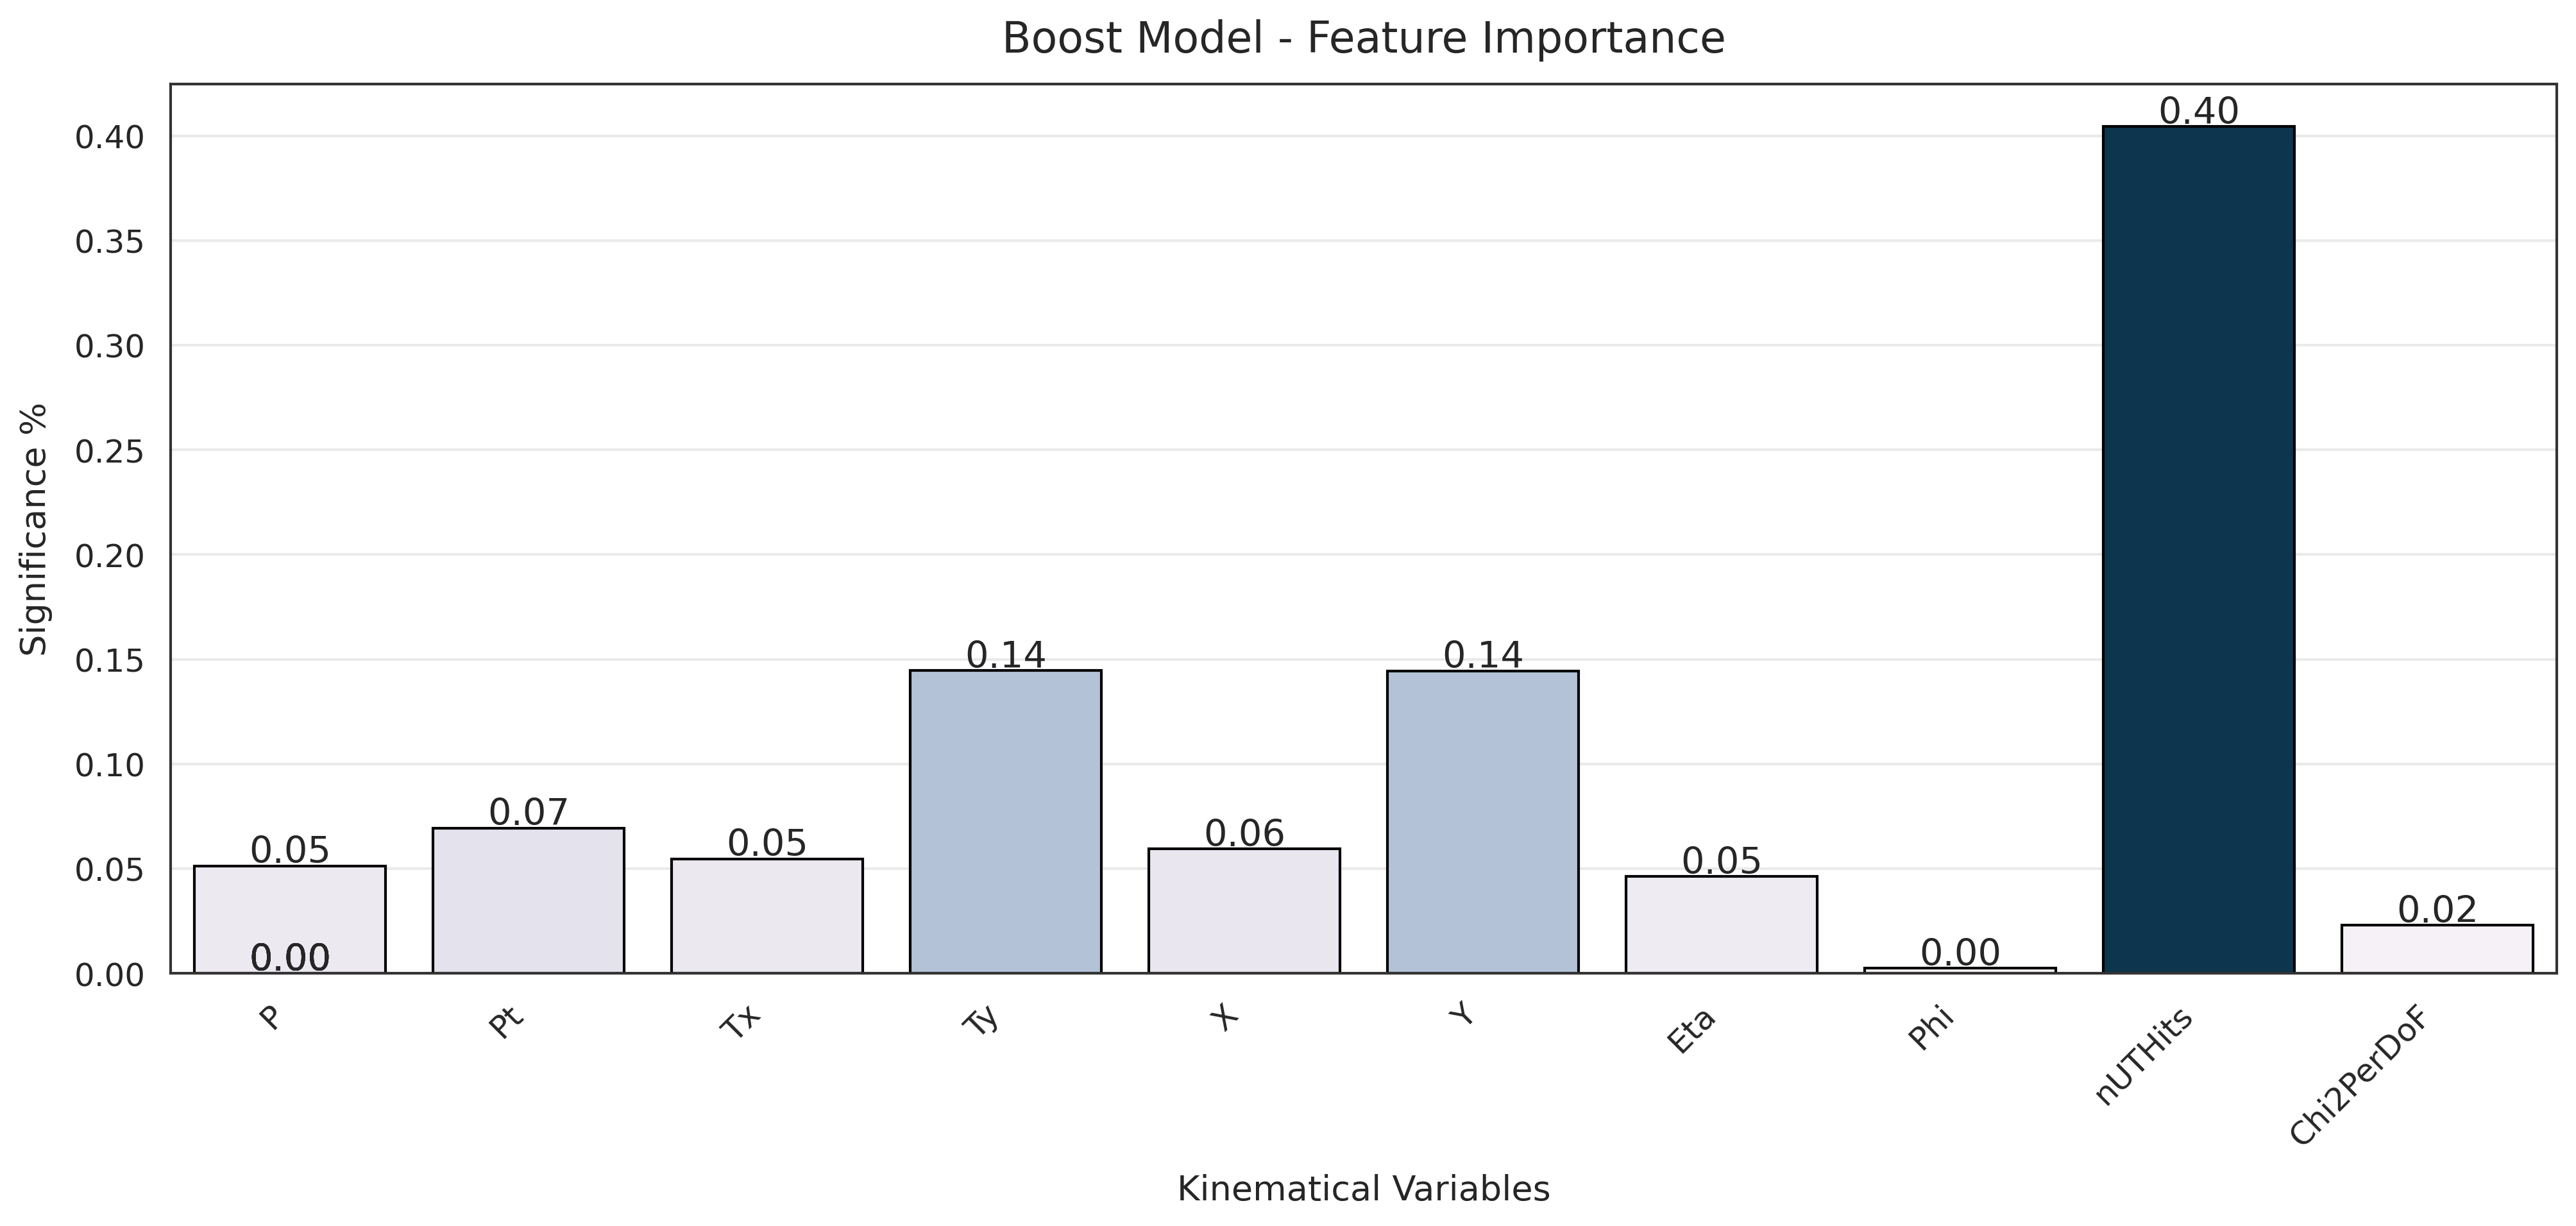

In [8]:
# FeatureImportance
plt.figure(figsize=(16, 6))
featureImportance = model.feature_importances_ / np.sum(model.feature_importances_)

ax=sns.barplot(x=columns, y=featureImportance,hue=model.feature_importances_,edgecolor='black',palette='PuBu')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')
plt.title('Boost Model - Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Kinematical Variables')
plt.ylabel('Significance %')
ax.legend_.remove()
plt.savefig(f"{figure_directory}/Downstream_Catboost_FI.png")
plt.show()


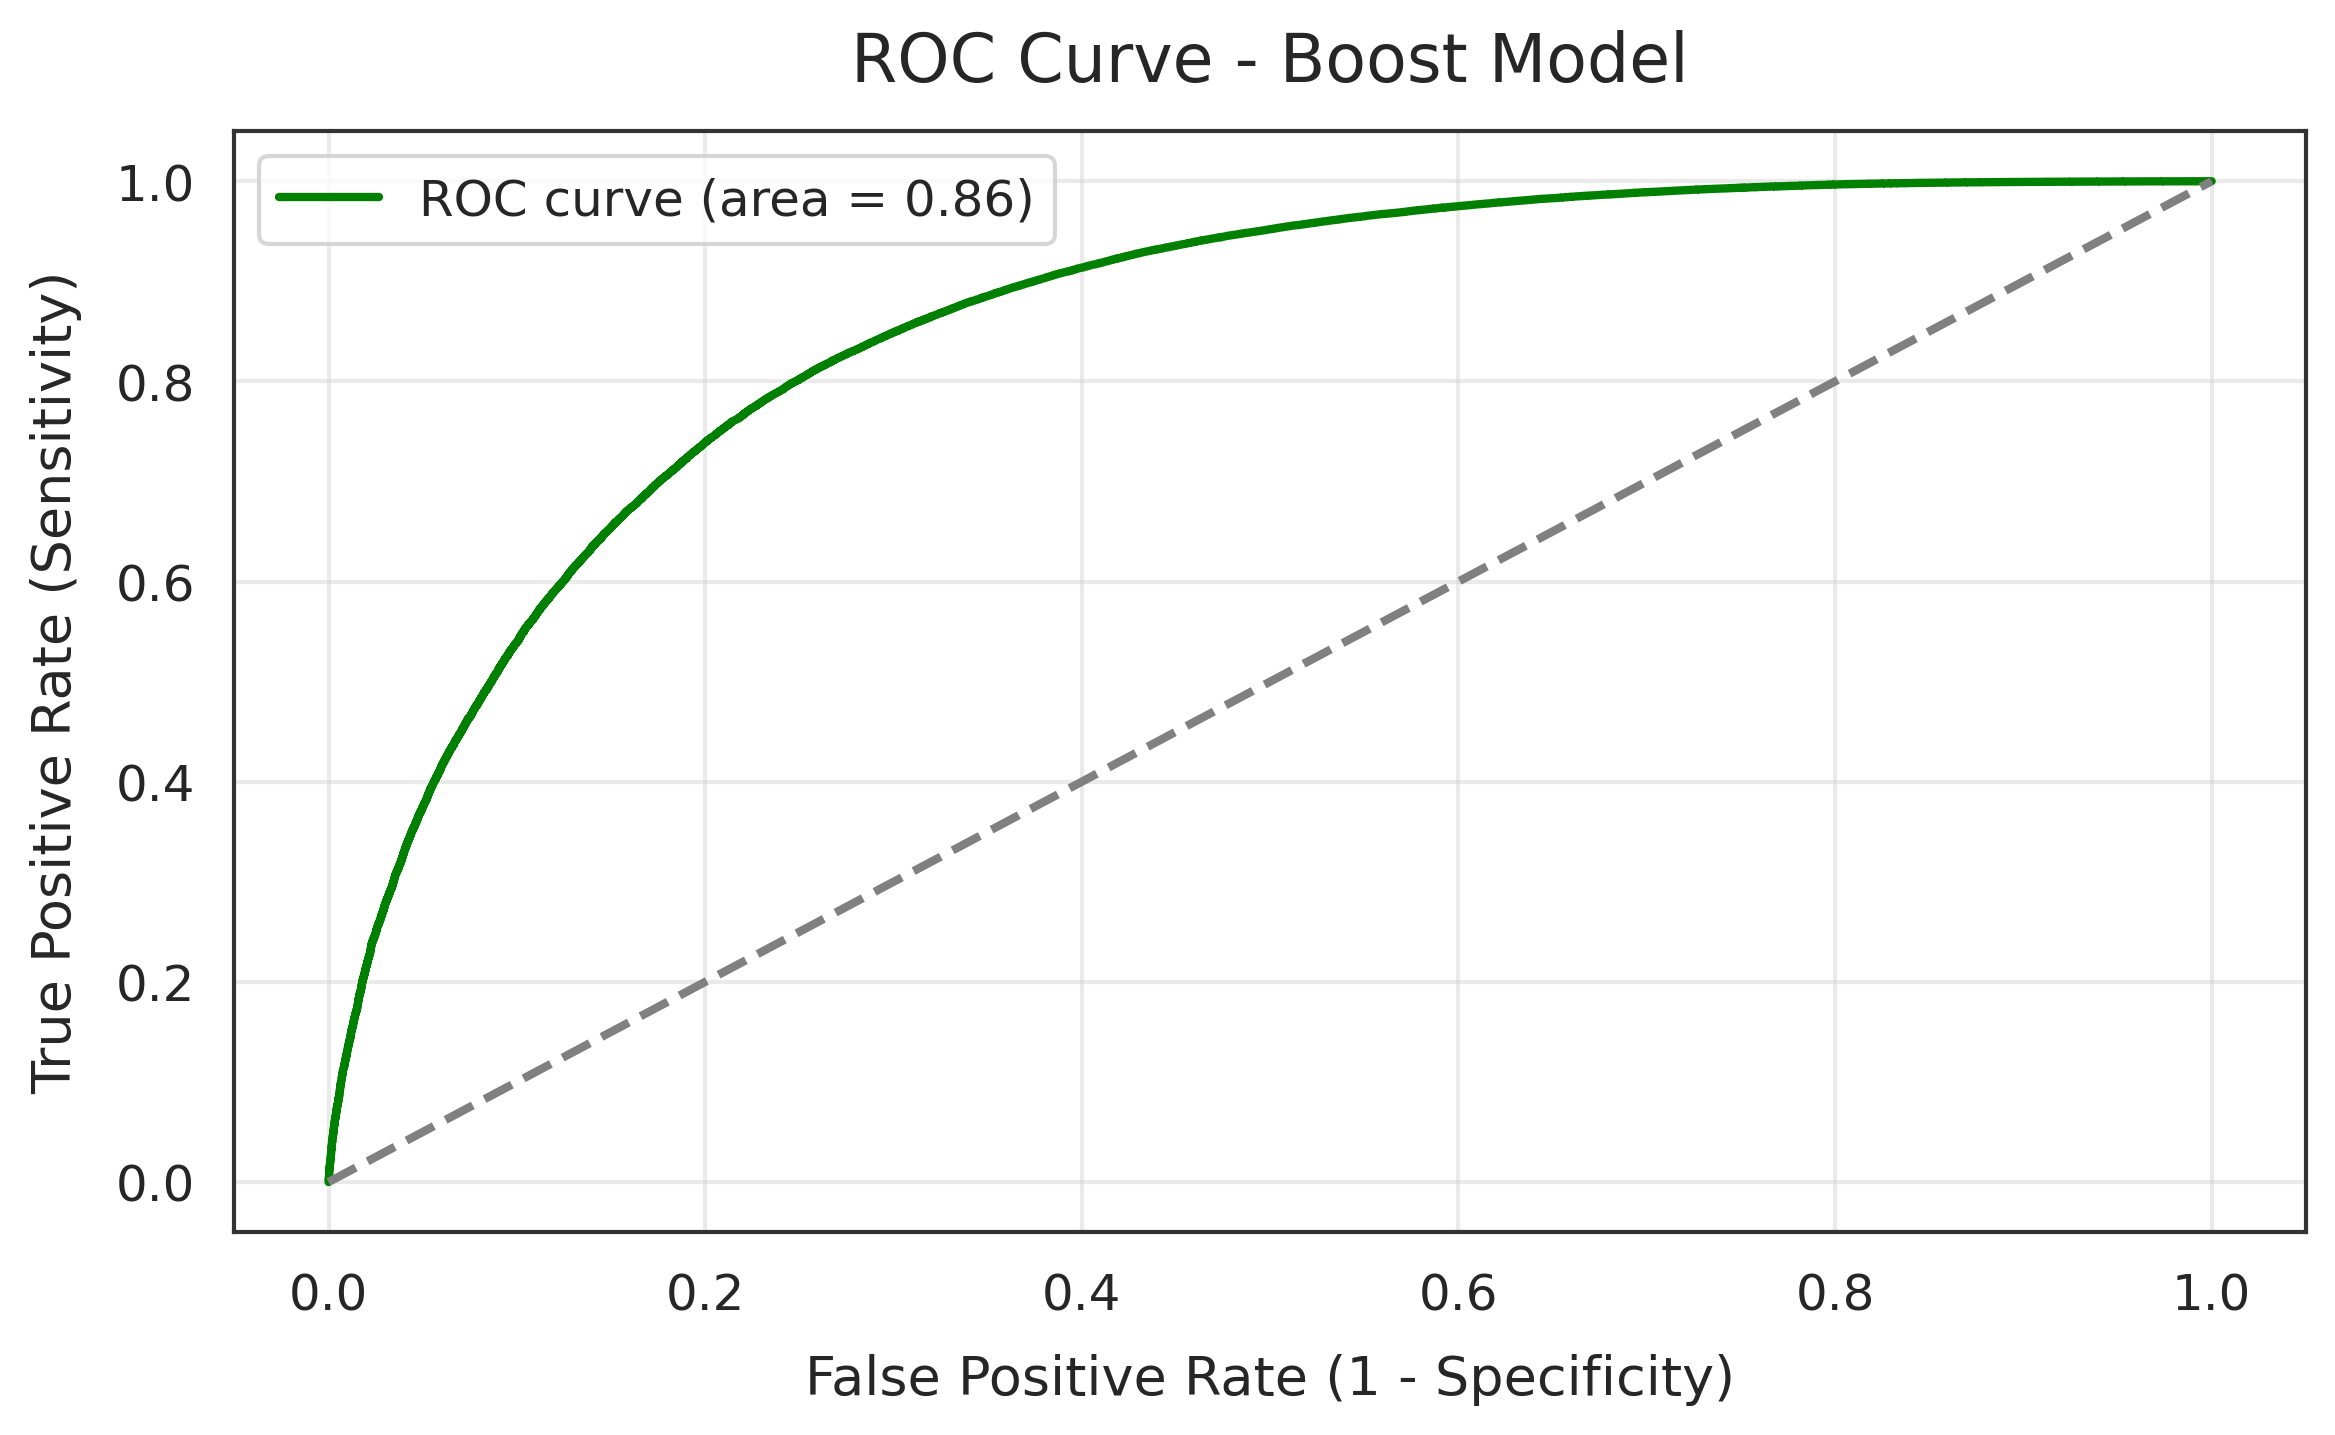

In [9]:
from sklearn.metrics import roc_curve,auc

evaluation=x_test.copy()

probabilityValue = model.predict_proba(evaluation)[:,1] #First Probability will make the plot upside down
fpr, tpr, threshold =roc_curve(y_test,  probabilityValue)

plt.figure(figsize=(8, 5))
plt.title('ROC Curve - Boost Model')
plt.plot(fpr, tpr,color='Green',label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(f"{figure_directory}/Downstream_Catboost_ROC.png")
plt.show()



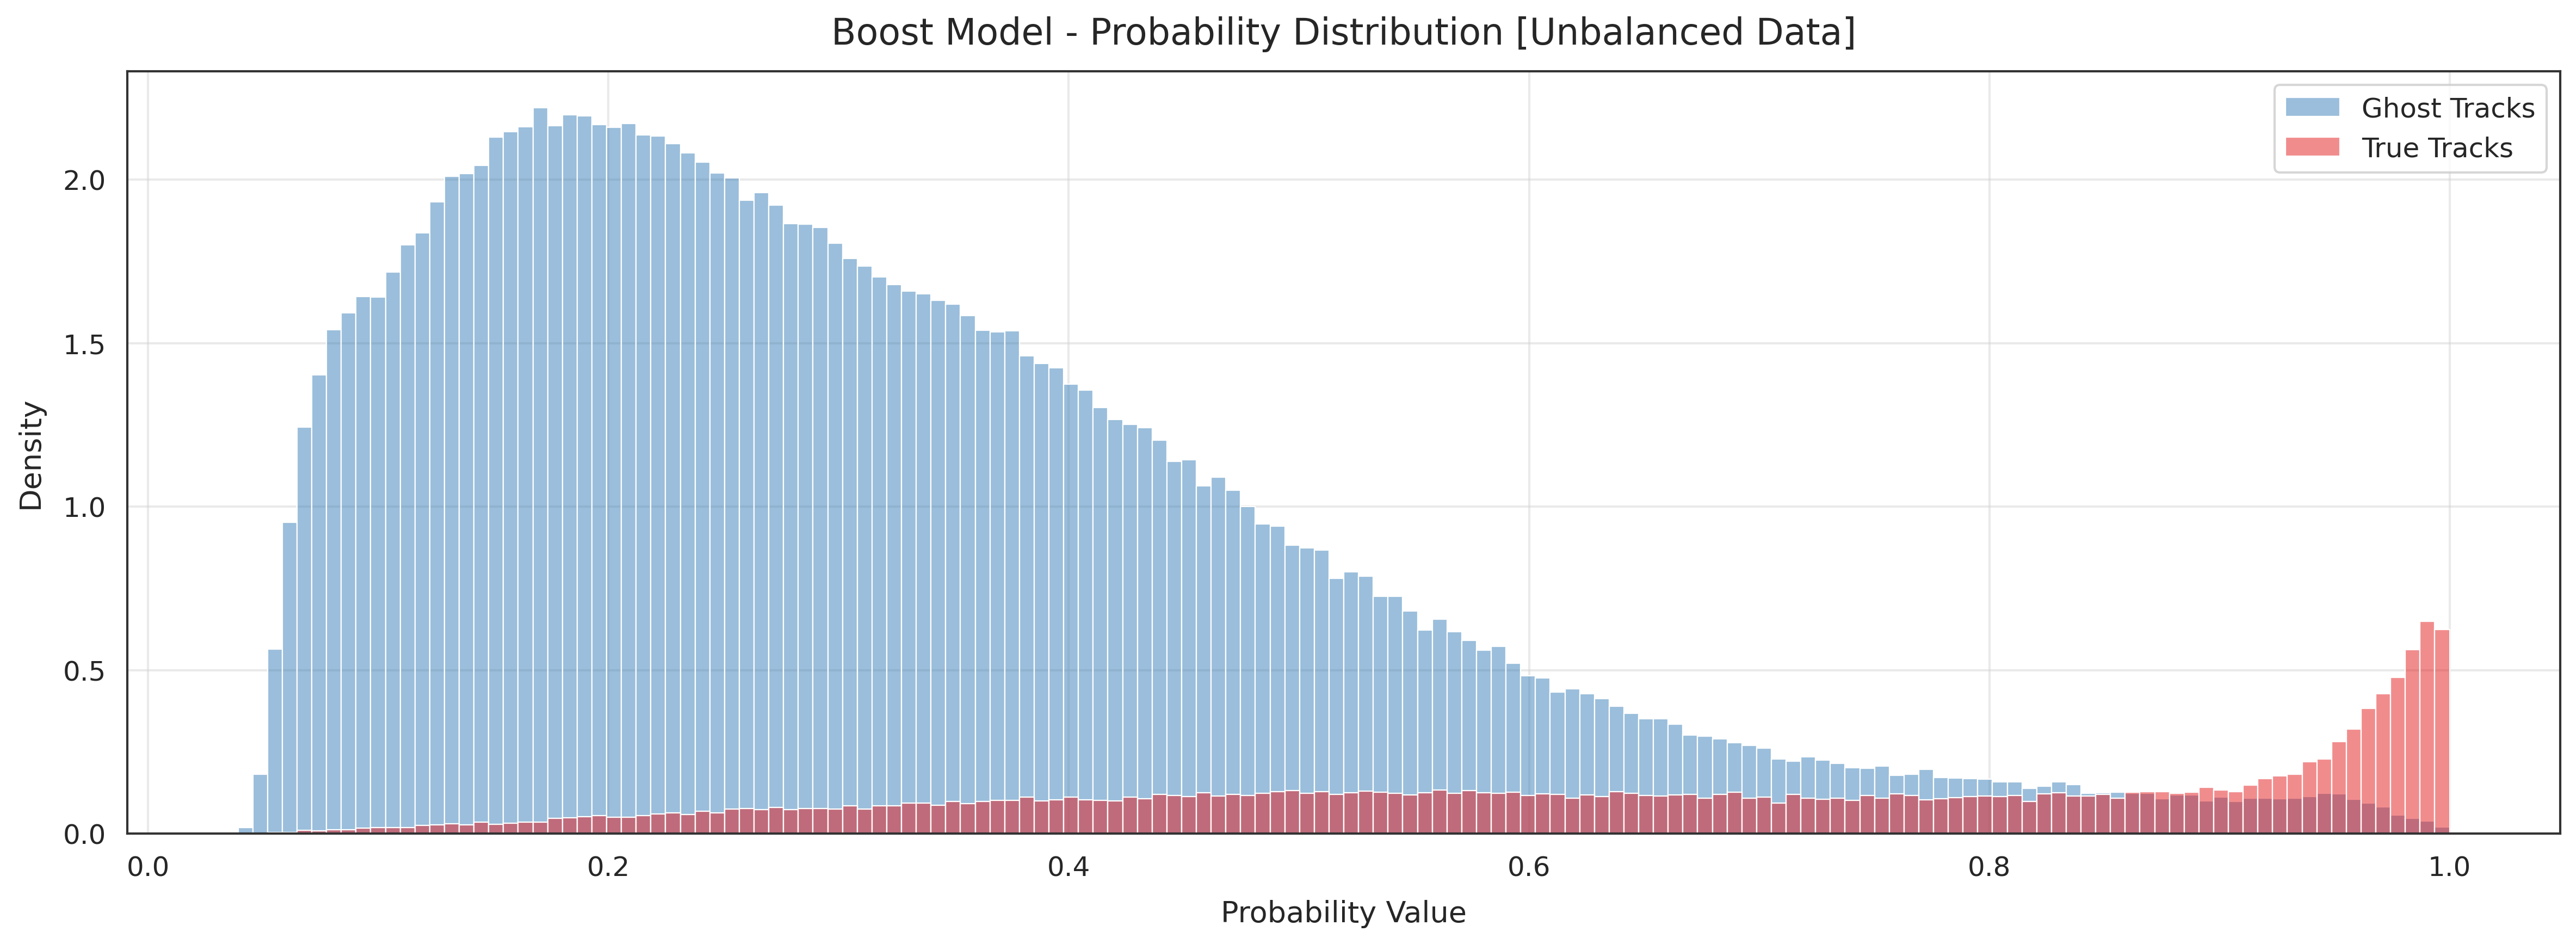

In [10]:
evaluation=x_test.copy()

probabilityValue = model.predict_proba(evaluation)[:,0] #Keeping the first set of probability for the distribution analysis
evaluation['ProbabilityValues']=probabilityValue
evaluation['TrueLabels']=y_test.values

plt.figure(figsize=(16, 6))
plt.title('Boost Model - Probability Distribution [Unbalanced Data]')
sns.histplot( x=evaluation['ProbabilityValues'], hue=evaluation['TrueLabels'], stat='density', bins=150, palette='Set1')
plt.xlabel('Probability Value')
plt.legend(labels=['Ghost Tracks', 'True Tracks'])
plt.savefig(f"{figure_directory}/Downstream_Catboost_ProbDist_Unbalanced.png")
plt.tight_layout()
plt.show()

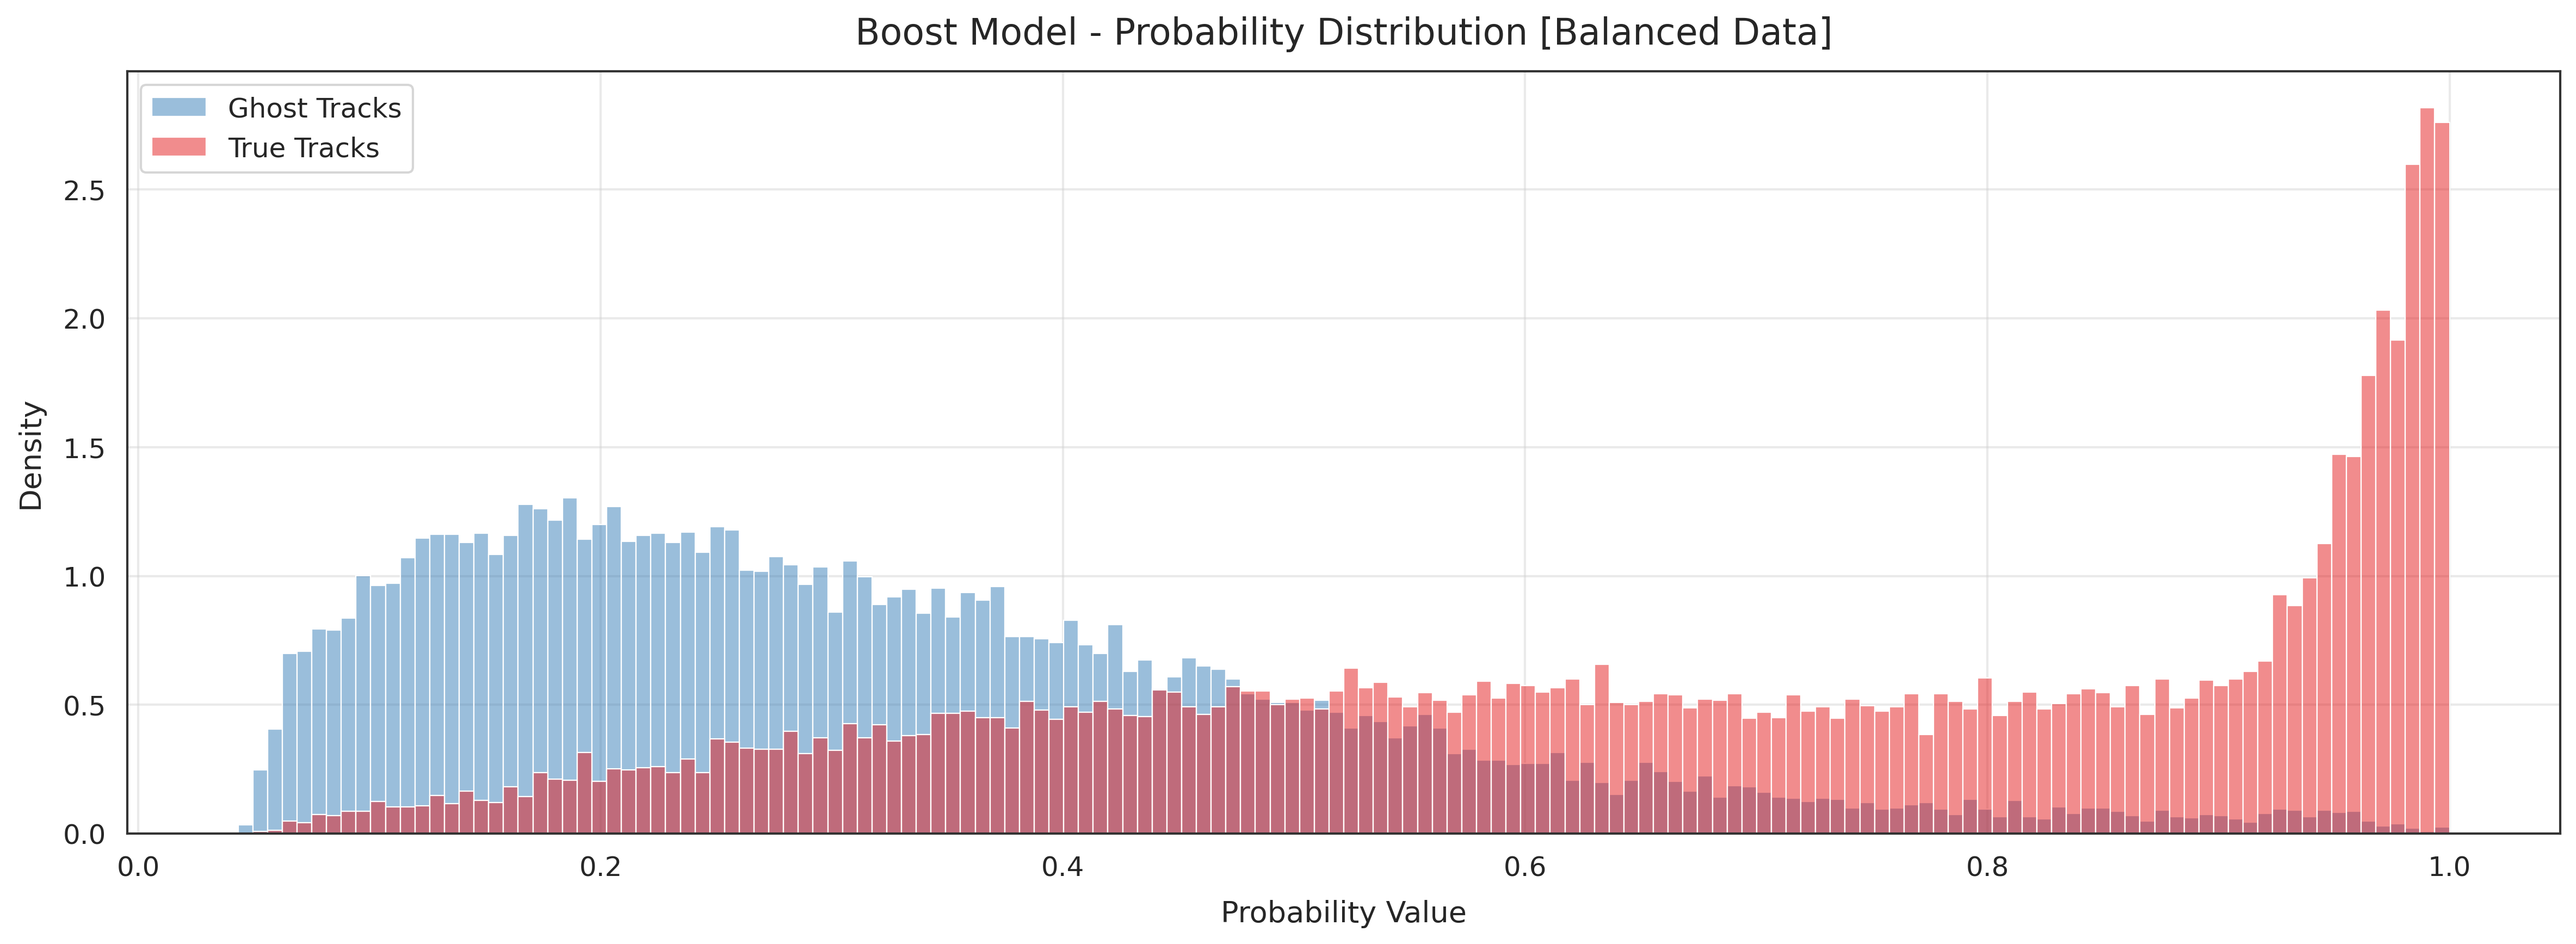

In [11]:
#Unlike previous notebooks, eval upsampling only here, for visualisation; no effects on training.
x_eval_balanced, y_eval_balanced = sampler.fit_resample(x_eval, y_eval)
evaluation=x_eval_balanced.copy()

probabilityValue = model.predict_proba(evaluation)[:,0] #Keeping the first set of probability for the distribution analysis
evaluation['ProbabilityValues']=probabilityValue
evaluation['TrueLabels']=y_eval_balanced.values

plt.figure(figsize=(16, 6))
plt.title('Boost Model - Probability Distribution [Balanced Data]')
sns.histplot( x=evaluation['ProbabilityValues'], hue=evaluation['TrueLabels'], stat='density', bins=150, palette='Set1')
plt.xlabel('Probability Value')
plt.legend(labels=['Ghost Tracks', 'True Tracks'])
plt.savefig(f"{figure_directory}/Downstream_Catboost_ProbDist_Balanced.png")
plt.tight_layout()
plt.show()

In [12]:
scaler.data_min_

array([ 1.37456251e+03,  5.12070907e+00, -4.09728527e-01, -2.65848875e-01,
       -7.70063110e+02, -6.20070984e+02,  1.57686504e+00, -3.14158511e+00,
        3.00000000e+00,  1.88820646e-03])

In [13]:
scaler.data_max_

array([5.42134504e+06, 2.75413205e+05, 4.02373552e-01, 2.66040862e-01,
       7.71442993e+02, 6.08441223e+02, 6.56953424e+00, 3.14155152e+00,
       8.00000000e+00, 4.99900770e+00])

In [14]:
#CPP Standalone
model.save_model('../../../../Models/StandaloneDownstreamModel.cpp',format='cpp',pool=train_data)

#JSON
model.save_model('../../../../Models/JsonDownstreamModel.json',format='json',pool=train_data)

In [15]:
import json

feature_mins = list(scaler.data_min_)
feature_maxs = list(scaler.data_max_)

with open("../../../../Models/JsonDownstreamModel.json", "r") as f:
    model_json = json.load(f)

model_json["feature_mins"] = feature_mins
model_json["feature_maxs"] = feature_maxs


with open("../../../../Models/JsonDownstreamModel_withScaling.json", "w") as f:
    json.dump(model_json, f, indent=2)

print("JSON Model saved with Scaling Factors")


JSON Model saved with Scaling Factors


In [16]:
#Evaluation
input_data = np.zeros(10)

input_data_df = pd.DataFrame(input_data.reshape(1, -1), columns=columns)  # Use the correct column names
input_data_scaled = scaler.transform(input_data_df)  # Transform the data using the scaler

probability = model.predict_proba(input_data_scaled)  # Get the probabilities
print("Probability of GhostTrack: ", probability[0][0])
print("Probability of TrueTrack: ", probability[0][1])


Probability of GhostTrack:  0.9615871237709452
Probability of TrueTrack:  0.038412876229054746


In [17]:
#End of Notebook